In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [140]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [5]:
file_train_name='./Titanic_data/train.csv'
file_test_name='./Titanic_data/test.csv'
Train=pd.read_csv(file_train_name,index_col='PassengerId')
Test=pd.read_csv(file_test_name,index_col='PassengerId')

print("Train shape",Train.shape,"\nTest shape",Test.shape)
display(Train.head(5))
print('Train Null')
print(Train.isnull().sum())
print('Test Null')
print(Train.isnull().sum())
Train.describe()

target=Train['Survived']
Train.drop(['Survived'],axis=1,inplace=True)
Full=Train.append(Test)
Full.reset_index(inplace=True)
Full.drop(['PassengerId'],axis=1,inplace=True)
Full.shape

Train shape (891, 11) 
Test shape (418, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Train Null
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64
Test Null
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


(1309, 10)

# EDA
## 分析Age

,Sex,Survived
0,female,0.742038
1,male,0.188908


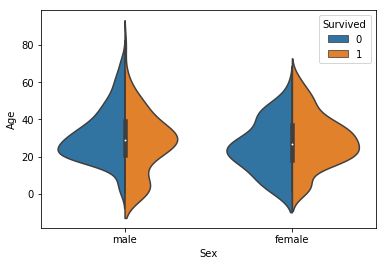

In [7]:
Data=pd.read_csv(file_train_name)
display(Data[['Sex','Survived']].groupby(['Sex'],as_index=False).mean())
sns.violinplot(x='Sex',y='Age',hue='Survived',data=Data,split=True)

## 分析Fare

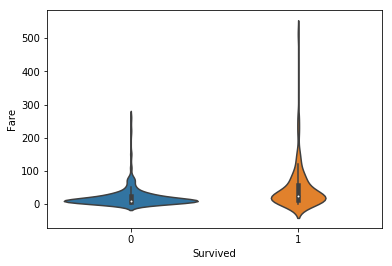

In [8]:
sns.violinplot(x='Survived',y='Fare',data=Data)

## 分析Embarked

In [9]:
Data[['Embarked','Survived']].groupby(['Embarked']).mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


# 数据处理
## 将Name进行映射

In [12]:
title=set()
for name in Data['Name']:
    title.add(name.split(',')[1].split('.')[0].strip())
print(title,len(title))

Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}


Full['Title']=Full['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
Full['Title']=Full['Title'].map(Title_Dictionary)


{'Lady', 'Miss', 'Rev', 'Mr', 'Dr', 'Mlle', 'Col', 'Jonkheer', 'Mrs', 'Don', 'Master', 'Mme', 'Major', 'Capt', 'the Countess', 'Sir', 'Ms'} 17


In [16]:
group_Age=Full[:891][['Sex','Pclass','Title','Age']].groupby(['Sex','Pclass','Title']).median()
group_Age=group_Age.reset_index()

In [17]:
group_Age.head()

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0


In [18]:
A=group_Age.set_index(['Sex','Pclass','Title']).T.to_dict("list")

## 填充Age的缺失值

In [19]:
Full['Age']=Full.apply(lambda x: A[(x['Sex'],x['Pclass'],x['Title'])][0] if(np.isnan(x['Age'])) else x['Age'],axis=1)
Full.head(6)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
5,3,"Moran, Mr. James",male,26.0,0,0,330877,8.4583,NaN,Q,Mr


## 对Name提取后得到的Title进行独热编码

In [25]:
title_dummies = pd.get_dummies(Full['Title'],prefix='Title')
Full=pd.concat([Full,title_dummies],axis=1)
Full.drop(['Name','Title'],axis=1,inplace=True)

In [26]:
Full.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


## 填充Fare的缺失值

In [38]:
Full['Fare'].fillna(Full[:891]['Fare'].mean(),inplace=True)

0

## 填充Embarked的缺失值并进行独热编码

In [42]:
print(Full[:891]['Embarked'].value_counts())
Full['Embarked'].fillna('S',inplace=True)
Embark_dummies=pd.get_dummies(Full['Embarked'],prefix='Embarked')
Full=pd.concat([Full,Embark_dummies],axis=1)
Full.drop(['Embarked'],axis=1,inplace=True)

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [43]:
Full.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,C123,0,0,0,1,0,0,0,0,1
4,3,male,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,0,0,0,1


## 填充Cabin的缺失值并进行独热编码

In [44]:
Full['Cabin'].fillna('U',inplace=True)
Full['Cabin']=Full['Cabin'].map(lambda x: x[0])
Cabin_dummies=pd.get_dummies(Full['Cabin'],prefix='Cabin')
Full=pd.concat([Full,Cabin_dummies],axis=1)
Full.drop(['Cabin'],axis=1,inplace=True)

In [45]:
Full.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,male,22.0,1,0,A/5 21171,7.2500,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,3,male,35.0,0,0,373450,8.0500,0,0,1,...,1,0,0,0,0,0,0,0,0,1


## 对Sex进行映射

In [46]:
Full['Sex']=Full['Sex'].map({"male":0,"female":1})
Full.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,0,22.0,1,0,A/5 21171,7.2500,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,1,38.0,1,0,PC 17599,71.2833,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,1,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,1,35.0,1,0,113803,53.1000,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,3,0,35.0,0,0,373450,8.0500,0,0,1,...,1,0,0,0,0,0,0,0,0,1


## 对Pclass进行独热编码

In [47]:
Pclass_dummies=pd.get_dummies(Full['Pclass'],prefix='Pclass')
Full=pd.concat([Full,Pclass_dummies],axis=1)
Full.drop(['Pclass'],axis=1,inplace=True)
Full.head()

,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,A/5 21171,7.2500,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,1,38.0,1,0,PC 17599,71.2833,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,1,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1,35.0,1,0,113803,53.1000,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,0,35.0,0,0,373450,8.0500,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


## 对Ticket提取前缀

In [95]:
se=set()
def Pre_Ticket_num(tick):
    tick=tick.replace('/','')
    tick=tick.replace('.','')
    tick=tick.split(' ')
    tick=map(lambda x: x.strip(),tick)
    tick=list(filter(lambda x: not x.isdigit(),tick))
    if len(tick)>0:
        return tick[0]
    else:
        return "XXX"

for i in Full['Ticket']:
    se.add(Pre_Ticket_num(i))
    
print(len(se))

Full['Ticket']=Full['Ticket'].map(Pre_Ticket_num)
Full.head()

37


,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,A5,7.2500,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,1,38.0,1,0,PC,71.2833,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,1,26.0,0,0,STONO2,7.9250,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1,35.0,1,0,XXX,53.1000,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,0,35.0,0,0,XXX,8.0500,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


## 对Ticket进行独热编码

In [96]:
Ticket_dummies=pd.get_dummies(Full['Ticket'],prefix='Ticket')
Full=pd.concat([Full,Ticket_dummies],axis=1)
Full.drop(['Ticket'],inplace=True,axis=1)

In [97]:
Full.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## 根据Parch和Sibsp形成新的特征

In [99]:
Full['Family']=Full['Parch']+Full['SibSp']+1
Full['Small']=Full['Family'].map(lambda x: 1 if x==1 else 0)
Full['Median']=Full['Family'].map(lambda x: 1 if 2<=x<=4 else 0)
Full['Large']=Full['Family'].map(lambda x: 1 if x>=5 else 0)

In [100]:
Full.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,Family,Small,Median,Large
0,0,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,2,0,1,0
1,1,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,2,0,1,0
2,1,26.0,0,0,7.9250,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3,1,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,1,2,0,1,0
4,0,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0


In [103]:
def compute_score(clf,X,y,scoring="accuracy"):
    val=cross_val_score(clf,X,y,scoring=scoring)
    return np.mean(val)

## 用RF进行了特征选择(并没有什么用....)

In [73]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(Train,Y)

In [107]:
Train,Test=Full[:891],Full[891:]

(891,)

In [118]:
clf=RandomForestClassifier(n_estimators=50,max_features='sqrt',random_state=1)
clf=clf.fit(Train,target)

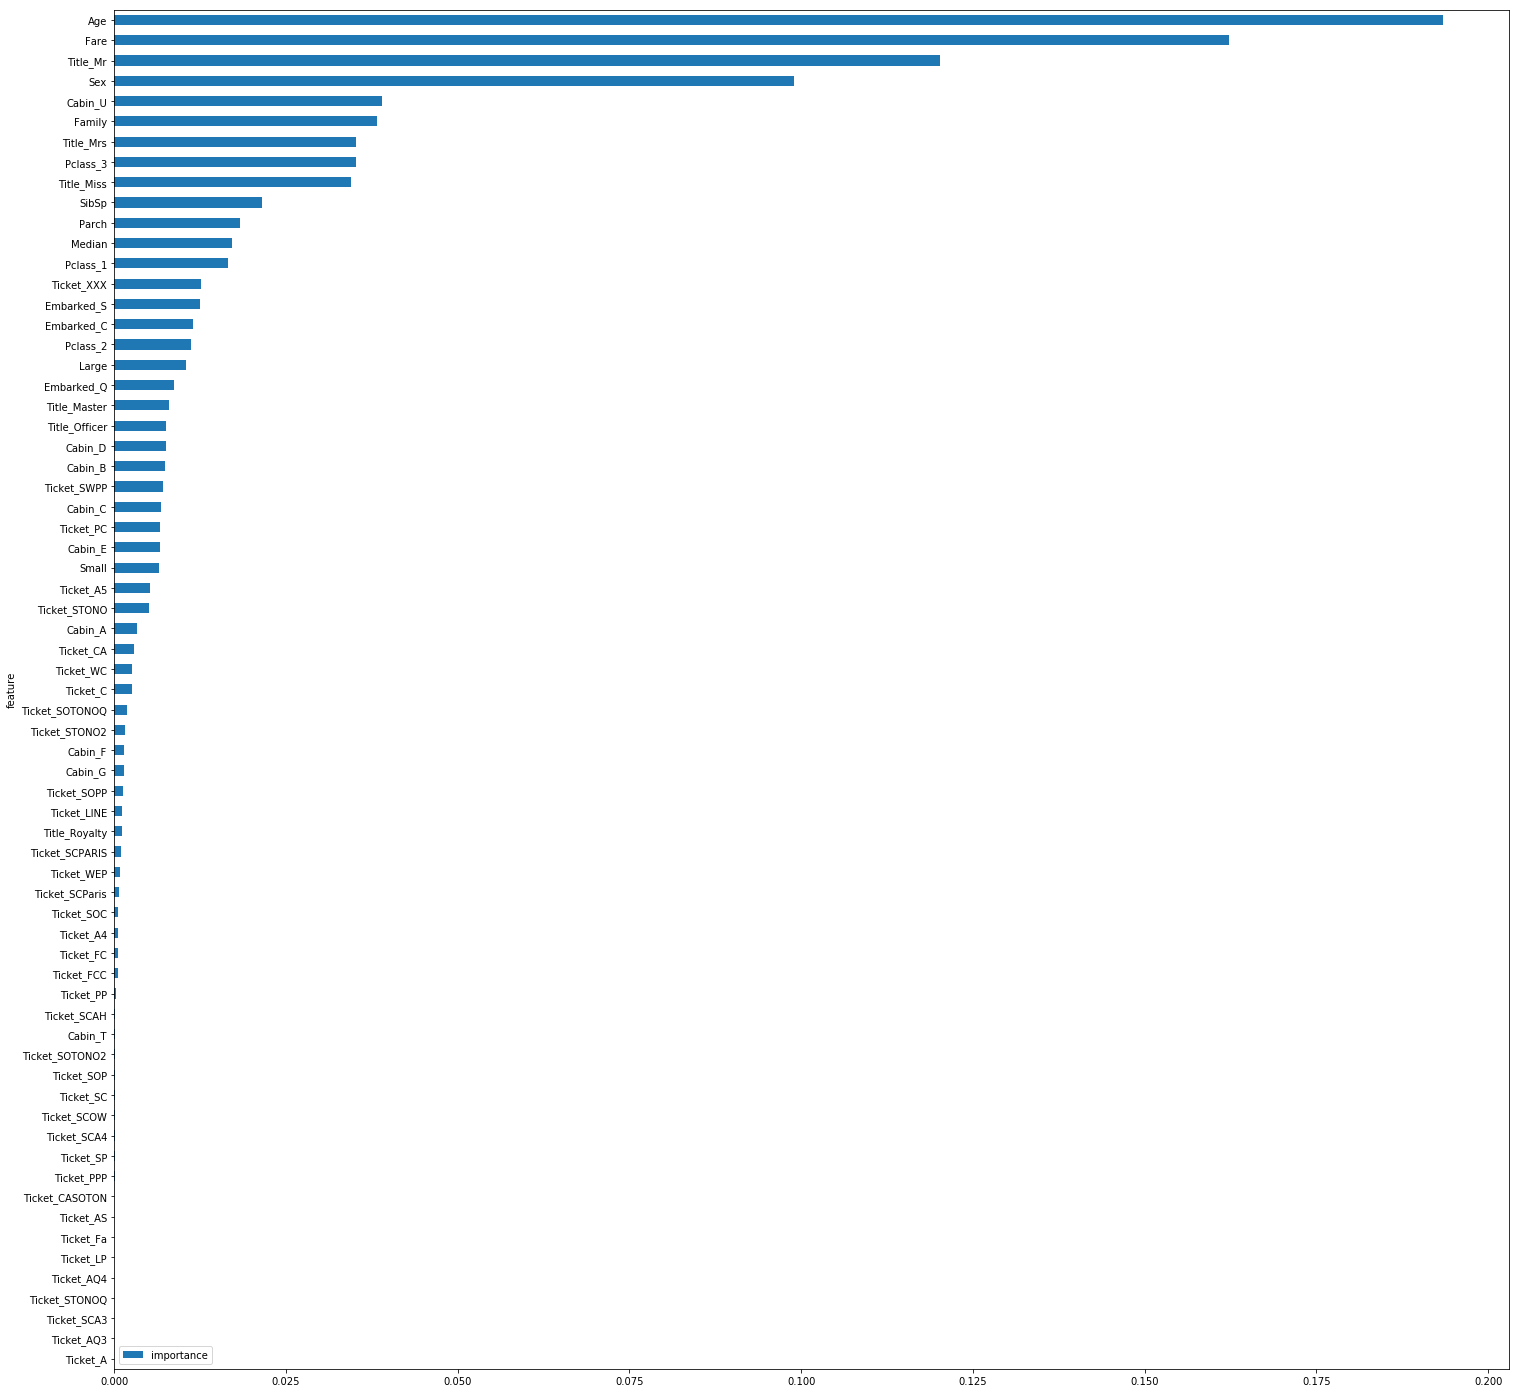

In [119]:
features = pd.DataFrame()
features['feature'] = Train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(25, 25))

In [121]:
model = SelectFromModel(clf, prefit=True)
Train_reduced = model.transform(Train)
Test_reduced = model.transform(Test)
print(Train_reduced.shape)
print(Test_reduced.shape)

(891, 13)
(418, 13)


In [122]:
Log=LogisticRegression()
Log_cv=LogisticRegressionCV()
rf=RandomForestClassifier()
gbt=GradientBoostingClassifier()

model=[Log,Log_cv,rf,gbt]

for x in model:
    print(x.__class__)
    print(compute_score(x,Train_reduced,target,scoring="accuracy"))

<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.8159371492704826
<class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
0.8125701459034792
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
0.7912457912457912
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
0.8215488215488215


## 对RF进行调参，并最终得到结果

In [147]:
model=RandomForestClassifier()
para={
    'max_depth' : [4, 6, 8],
    'n_estimators': [50, 10],
    'max_features': ['sqrt', 'auto', 'log2'],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'bootstrap': [True, False],
}
grid=GridSearchCV(model,scoring="accuracy",param_grid=para,cv=StratifiedKFold(n_splits=5),verbose=1)
model=grid.fit(Train,target)
print(grid.best_params_,grid.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'bootstrap': False, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 10} 0.8383838383838383


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:   46.2s finished


In [148]:
Id=pd.read_csv(file_test_name)
csv=pd.DataFrame({'PassengerId':Id['PassengerId'],'Survived':model.predict(Test)})
# csv.to_csv('./kaggle_Ans/Titanic_ans.csv',index=False)


## discussion中还有许多trick，未来还会不断完善...
## 主要参考于 https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
### 主要还是为了记录一下自己一个相对完整的kaggle流程